### **LSI Topic Modeling**
### Scrape .pdf files
We only need to do this one time to download the files into the folder you're working in.

In [1]:
import os
import re

import pandas as pd
import pdfplumber
import requests
import gensim
import nltk

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from collections import namedtuple
from bs4 import BeautifulSoup as bs
from gensim.models import CoherenceModel

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Leila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Leila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Leila\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [27]:
DOMAIN = "https://papers.xtremepape.rs/"
URL = "https://papers.xtremepape.rs/index.php?dirpath=./CAIE/IGCSE/Geography+%280460%29/&order=1"
FILETYPE = ".pdf"

output_folder = "pdf_files"
os.makedirs(output_folder, exist_ok=True)

def get_soup(url):
    return bs(requests.get(url).text, 'html.parser')

for link in get_soup(URL).find_all('a'):
    file_link = link.get('href')
    if file_link.startswith('CAIE/IGCSE') and FILETYPE in file_link and "_qp_2" in file_link:
        print(file_link)
        try:
            file_path = os.path.join(output_folder, link.text)
            with open(link.text, 'wb') as file:
                response = requests.get(DOMAIN + file_link)
                file.write(response.content)
        except Exception as e:
            print("Error downloading file:", e)
            continue


CAIE/IGCSE/Geography (0460)/0460_w21_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w21_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w21_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w20_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w20_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w20_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w19_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w19_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w19_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w18_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w18_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w18_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w17_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w17_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w17_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w16_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w16_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w16_qp_21.pdf
CAIE/IGCSE/Geography (0460)/0460_w15_qp_23.pdf
CAIE/IGCSE/Geography (0460)/0460_w15_qp_22.pdf
CAIE/IGCSE/Geography (0460)/0460_w15_qp_21.pdf
CAIE/IGCSE/Ge

### Import Data
> *Start running from the cell below if you've already imported the files previously.*

In [7]:
Line = namedtuple('Line', 'Paper_ID Question_ID Question_Type Question_Text Token_Text Word_Count')
# file = '0460_w21_qp_22.pdf'

### Pre-processing

In [8]:
total_check = 0
skip_lines = True
concatenate = True
questionNo = 1

concatenated_lines = []

data = []

ignore_patterns = [
    r'^\d+\s*[A-Z]+\s*\d+/\d+/\d+',  # Lines with exam details
    r'^\d+\s*(BLANK PAGE|TURN OVER|Additional Pages)',  # Lines indicating blank pages or page turns
    r'^\[Total:\s*\d+\]$',  # Lines starting with total marks
    r'^© UCLES \d+\s*$',  # Lines starting with copyright information
    r'^\.{3,}',  # Lines starting with three or more dots
    r'\.{10,}', # Lines that contain three or more dots
    r'cid', # Lines that contain 'cid'
    r'© UCLES', # Lines that contain '© UCLES'
    r'^\d+( \d+)*$' # Lines that contain digits and spaces
]

current_dir = os.getcwd()
output_folder = "pdf_files"
pdf_folder_path = os.path.join(current_dir, output_folder)

files = [f for f in os.listdir(pdf_folder_path) if f.endswith('.pdf')]

for file in files:
    print(file)
    lines = []
    file_path = os.path.join(pdf_folder_path, file)
    with pdfplumber.open(file_path) as pdf:
        Paper_ID = file
        for page in pdf.pages:
            text = page.extract_text()
            for line in text.split('\n'):

                if any(re.search(pattern, line) for pattern in ignore_patterns):
                    # print(line)
                    continue
                elif len(line.strip()) <= 5:
                    continue
                elif 'Additional Pages' in line:
                    skip_lines = True
                    continue
                elif line.startswith('*') and line.endswith('*'):
                    skip_lines = False
                    continue
                elif skip_lines:
                    continue
                else:
                    lines.append(line.strip())

    concatenated_line = ''

    for line in lines:
        if line.startswith('(') == False and not re.search(r'^\d(\d\s| )', line):
            concatenated_line = concatenated_line + line + ' '
        else:
            if concatenated_line != "":
                concatenated_lines.append(concatenated_line.strip())
                
                if concatenated_line.startswith('('):
                    Question_Type = 'SUB'
                    Question_ID = re.search(r'^\((.*?)\)', concatenated_line).group(0)
                elif re.search(r'^\d(\d\s| )', concatenated_line):
                    Question_Type = 'MAIN'
                    Question_ID = re.search(r'^\d(\d\s| )', concatenated_line).group(0)
                    # Question_Text = re.search(r'^\((.*?)\)', line).group(2)

                Question_Text = concatenated_line.replace(str(Question_ID), "")
                Token_Question_Text = word_tokenize(Question_Text)
                tags = pos_tag(Token_Question_Text)
                filtered_words = [word for word in Token_Question_Text 
                  if (len(word) > 1) and 
                     (not re.match(r'^\d+\.\d$', word)) and
                     (word.lower() not in stopwords.words('english'))]
                # filtered_nouns = [word for word, pos in tags if (pos == 'NN' or pos == 'NNS') and (len(word) > 1) and word.lower() not in stopwords.words('english')]
                # Token_Text = ' '.join(filtered_nouns)
                Token_Text = ' '.join(filtered_words)
                Word_Count = len(Question_Text)
                data.append(Line(Paper_ID, Question_ID, Question_Type, Question_Text, Token_Text, Word_Count))
                # print(concatenated_line)
            concatenated_line = line + ' '
        
print(concatenated_lines)


0460_m17_qp_22.pdf
0460_m18_qp_22.pdf
0460_m19_qp_22.pdf
0460_m20_qp_22.pdf
0460_m21_qp_22.pdf
0460_m22_qp_22.pdf
0460_s14_qp_21.pdf
0460_s14_qp_22.pdf
0460_s14_qp_23.pdf
0460_s15_qp_21.pdf
0460_s15_qp_22.pdf
0460_s15_qp_23.pdf
0460_s16_qp_21.pdf
0460_s16_qp_22.pdf
0460_s16_qp_23.pdf
0460_s18_qp_21.pdf
0460_s18_qp_22.pdf
0460_s18_qp_23.pdf
0460_s19_qp_21.pdf
0460_s19_qp_22.pdf
0460_s19_qp_23.pdf
0460_s20_qp_21.pdf
0460_s20_qp_22.pdf
0460_s20_qp_23.pdf
0460_s21_qp_21.pdf
0460_s21_qp_22.pdf
0460_s21_qp_23.pdf
0460_s22_qp_21.pdf
0460_s22_qp_22.pdf
0460_s22_qp_23.pdf
0460_w14_qp_21.pdf
0460_w14_qp_22.pdf
0460_w14_qp_23.pdf
0460_w15_qp_21.pdf
0460_w15_qp_22.pdf
0460_w15_qp_23.pdf
0460_w16_qp_21.pdf
0460_w16_qp_22.pdf
0460_w16_qp_23.pdf
0460_w17_qp_21.pdf
0460_w17_qp_22.pdf
0460_w17_qp_23.pdf
0460_w18_qp_21.pdf
0460_w18_qp_22.pdf
0460_w18_qp_23.pdf
0460_w19_qp_21.pdf
0460_w19_qp_22.pdf
0460_w19_qp_23.pdf
0460_w20_qp_21.pdf
0460_w20_qp_22.pdf
0460_w20_qp_23.pdf
0460_w21_qp_21.pdf
0460_w21_qp_

### Basic Visualization

In [9]:
df = pd.DataFrame(data)
df.head(200)

,Paper_ID,Question_ID,Question_Type,Question_Text,Token_Text,Word_Count
0,0460_m17_qp_22.pdf,1,MAIN,"Study the map extract for Ballyvaghan, Ireland...",Study map extract Ballyvaghan Ireland scale 1:...,71
1,0460_m17_qp_22.pdf,(a),SUB,The map has blue grid lines which make square...,map blue grid lines make squares area land one...,126
2,0460_m17_qp_22.pdf,10,MAIN,km2,km2,4
3,0460_m17_qp_22.pdf,20,MAIN,km2,km2,4
4,0460_m17_qp_22.pdf,50,MAIN,km2 100 km2,km2 100 km2,12
...,...,...,...,...,...,...
195,0460_m21_qp_22.pdf,(iii),SUB,land use at C,land use,15
196,0460_m21_qp_22.pdf,(iv),SUB,feature D,feature,11
197,0460_m21_qp_22.pdf,(v),SUB,the height above sea level of the spot height...,height sea level spot height,53
198,0460_m21_qp_22.pdf,(b),SUB,A person travels on the footpath from the nor...,person travels footpath north river outside Co...,160


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2704 entries, 0 to 2703
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Paper_ID       2704 non-null   object
 1   Question_ID    2704 non-null   object
 2   Question_Type  2704 non-null   object
 3   Question_Text  2704 non-null   object
 4   Token_Text     2704 non-null   object
 5   Word_Count     2704 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 126.9+ KB


In [11]:
res = df.Token_Text.str.split(expand=True).stack().value_counts()
print(res.head(30))

Fig            1726
map             447
shows           433
shown           413
extract         338
population      313
Using           305
area            282
one             259
answer          248
Table           234
two             230
Study           221
Describe        217
river           215
Tick            213
features        189
information     176
settlement      159
road            159
feature         158
following       154
areas           148
Insert          146
south           143
north           139
use             138
metres          137
Total           126
height          124
Name: count, dtype: int64


In [12]:
res2 = df.Token_Text.str.split(expand=True).stack()
print(res2)

0     0           Study
      1             map
      2         extract
      3     Ballyvaghan
      4         Ireland
               ...     
2703  6        Identify
      7             one
      8           cause
      9      extinction
      10        species
Length: 32554, dtype: object


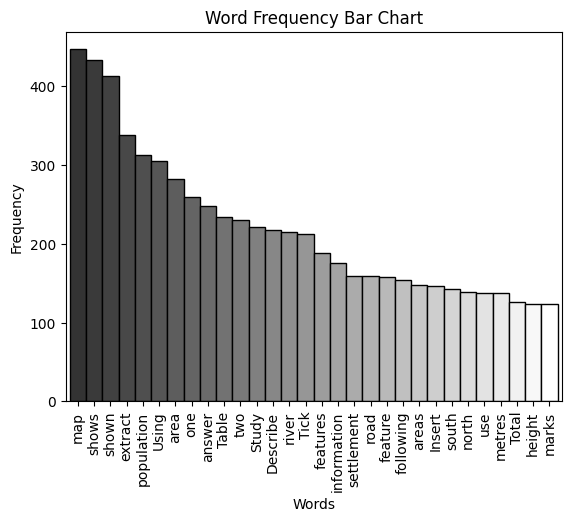

In [13]:
import matplotlib.pyplot as plt
import numpy as np

res.iloc[1:31].plot(kind='bar', color=plt.cm.gray(np.linspace(0.2, 1, 30)), edgecolor='black', width=1)

plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Bar Chart')

plt.show()

In [14]:
# df.to_csv('scrape.csv', index=True)
print(data)
print(df['Token_Text'].str.split().tolist())

[Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='1 ', Question_Type='MAIN', Question_Text='Study the map extract for Ballyvaghan, Ireland. The scale is 1:50 000. ', Token_Text='Study map extract Ballyvaghan Ireland scale 1:50 000', Word_Count=71), Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='(a)', Question_Type='SUB', Question_Text=' The map has blue grid lines which make squares. What area of land does one grid square show? Tick one answer below. Tick (3) ', Token_Text='map blue grid lines make squares area land one grid square show Tick one answer Tick', Word_Count=126), Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='10 ', Question_Type='MAIN', Question_Text='km2 ', Token_Text='km2', Word_Count=4), Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='20 ', Question_Type='MAIN', Question_Text='km2 ', Token_Text='km2', Word_Count=4), Line(Paper_ID='0460_m17_qp_22.pdf', Question_ID='50 ', Question_Type='MAIN', Question_Text='km2 100 km2 ', Token_Text='km2 100 km2', Word_Count=12), Li

### Bi-gram Phrase Model

In [15]:
word_list = df['Token_Text'].str.split().tolist()
print(word_list[0])
print(word_list)
bigram = gensim.models.Phrases(word_list, min_count=20, threshold=10) # higher threshold fewer phrases.
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[word_list[0]])
# set1 = set(word_list[0])
# set2 = set(bigram_model[word_list[0]])
# diff_in_list1 = set1 - set2
# print(diff_in_list1)

['Study', 'map', 'extract', 'Ballyvaghan', 'Ireland', 'scale', '1:50', '000']
[['Study', 'map', 'extract', 'Ballyvaghan', 'Ireland', 'scale', '1:50', '000'], ['map', 'blue', 'grid', 'lines', 'make', 'squares', 'area', 'land', 'one', 'grid', 'square', 'show', 'Tick', 'one', 'answer', 'Tick'], ['km2'], ['km2'], ['km2', '100', 'km2'], ['Height', 'sea', 'level', 'shown', 'contour', 'lines', 'difference', 'height', 'contour', 'lines', 'map', 'Tick', 'one', 'answer', 'Tick'], ['green', 'shading', 'grid', 'square', '2807', 'show'], ['Fig', 'shows', 'features', 'east', 'map', 'extract', 'Study', 'Fig', 'map', 'extract', 'answer', 'questions', 'Fig'], ['Identify', 'feature'], ['Identify', 'type', 'road'], ['Give', 'six-figure', 'grid', 'reference', 'road', 'junction'], ['Give', 'height', 'sea', 'level', 'spot', 'height'], ['Describe', 'gradient', 'road'], ['Fig', 'shows', 'location', 'coastal', 'settlements', 'Ballyvaghan', 'Bealaclugga', 'BBeeaallaacclluuggggaa', 'BBaallllyyvvaagghhaann', 'Fig

In [16]:
norm_corpus_bigrams = [bigram_model[q] for q in word_list]

dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Total Vocabulary Size:', len(dictionary))
print('Sample word to number mappings:', list(dictionary.items())[:30])
dictionary.filter_extremes(no_below=9)
print('Total Vocabulary Size:', len(dictionary))
print('Probed sample word to number mappings:', list(dictionary.items())[:30])

Total Vocabulary Size: 4785
Sample word to number mappings: [(0, '000'), (1, 'Ballyvaghan'), (2, 'Ireland'), (3, 'Study'), (4, 'map_extract'), (5, 'scale_1:50'), (6, 'Tick'), (7, 'Tick_one'), (8, 'answer'), (9, 'area'), (10, 'blue'), (11, 'grid'), (12, 'land'), (13, 'lines'), (14, 'make'), (15, 'map'), (16, 'one'), (17, 'show'), (18, 'square'), (19, 'squares'), (20, 'km2'), (21, '100'), (22, 'Height'), (23, 'contour'), (24, 'difference'), (25, 'height'), (26, 'sea_level'), (27, 'shown'), (28, '2807'), (29, 'green')]
Total Vocabulary Size: 636
Probed sample word to number mappings: [(0, '000'), (1, 'Ireland'), (2, 'Study'), (3, 'map_extract'), (4, 'scale_1:50'), (5, 'Tick'), (6, 'Tick_one'), (7, 'answer'), (8, 'area'), (9, 'blue'), (10, 'grid'), (11, 'land'), (12, 'map'), (13, 'one'), (14, 'show'), (15, 'square'), (16, 'squares'), (17, 'km2'), (18, '100'), (19, 'contour'), (20, 'difference'), (21, 'height'), (22, 'sea_level'), (23, 'shown'), (24, 'Fig'), (25, 'answer_questions'), (26, '

In [17]:
word_list_by_paper = df.groupby('Paper_ID')['Token_Text'].apply(lambda x: ' '.join(x)).str.split().tolist()
print(word_list[0])
print(word_list)
bigram = gensim.models.Phrases(word_list, min_count=20, threshold=10)
bigram_model = gensim.models.phrases.Phraser(bigram)

print(bigram_model[word_list[0]])

['Study', 'map', 'extract', 'Ballyvaghan', 'Ireland', 'scale', '1:50', '000']
[['Study', 'map', 'extract', 'Ballyvaghan', 'Ireland', 'scale', '1:50', '000'], ['map', 'blue', 'grid', 'lines', 'make', 'squares', 'area', 'land', 'one', 'grid', 'square', 'show', 'Tick', 'one', 'answer', 'Tick'], ['km2'], ['km2'], ['km2', '100', 'km2'], ['Height', 'sea', 'level', 'shown', 'contour', 'lines', 'difference', 'height', 'contour', 'lines', 'map', 'Tick', 'one', 'answer', 'Tick'], ['green', 'shading', 'grid', 'square', '2807', 'show'], ['Fig', 'shows', 'features', 'east', 'map', 'extract', 'Study', 'Fig', 'map', 'extract', 'answer', 'questions', 'Fig'], ['Identify', 'feature'], ['Identify', 'type', 'road'], ['Give', 'six-figure', 'grid', 'reference', 'road', 'junction'], ['Give', 'height', 'sea', 'level', 'spot', 'height'], ['Describe', 'gradient', 'road'], ['Fig', 'shows', 'location', 'coastal', 'settlements', 'Ballyvaghan', 'Bealaclugga', 'BBeeaallaacclluuggggaa', 'BBaallllyyvvaagghhaann', 'Fig

In [18]:
norm_corpus_bigrams = [bigram_model[p] for p in word_list]

dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Total Vocabulary Size:', len(dictionary))
print('Sample word to number mappings:', list(dictionary.items())[:30])
dictionary.filter_extremes(no_below=9)
print('Total Vocabulary Size:', len(dictionary))
print('Probed sample word to number mappings:', list(dictionary.items())[:30])

Total Vocabulary Size: 4785
Sample word to number mappings: [(0, '000'), (1, 'Ballyvaghan'), (2, 'Ireland'), (3, 'Study'), (4, 'map_extract'), (5, 'scale_1:50'), (6, 'Tick'), (7, 'Tick_one'), (8, 'answer'), (9, 'area'), (10, 'blue'), (11, 'grid'), (12, 'land'), (13, 'lines'), (14, 'make'), (15, 'map'), (16, 'one'), (17, 'show'), (18, 'square'), (19, 'squares'), (20, 'km2'), (21, '100'), (22, 'Height'), (23, 'contour'), (24, 'difference'), (25, 'height'), (26, 'sea_level'), (27, 'shown'), (28, '2807'), (29, 'green')]
Total Vocabulary Size: 636
Probed sample word to number mappings: [(0, '000'), (1, 'Ireland'), (2, 'Study'), (3, 'map_extract'), (4, 'scale_1:50'), (5, 'Tick'), (6, 'Tick_one'), (7, 'answer'), (8, 'area'), (9, 'blue'), (10, 'grid'), (11, 'land'), (12, 'map'), (13, 'one'), (14, 'show'), (15, 'square'), (16, 'squares'), (17, 'km2'), (18, '100'), (19, 'contour'), (20, 'difference'), (21, 'height'), (22, 'sea_level'), (23, 'shown'), (24, 'Fig'), (25, 'answer_questions'), (26, '

### Latent Semantic Indexing (LSI)

In [19]:
corpus = [dictionary.doc2bow(text) for text in norm_corpus_bigrams]
print([(dictionary[idx] , freq) for idx, freq in corpus[1][:50]])
print('Total number of questions:', len(corpus))

[('Tick', 1), ('Tick_one', 1), ('answer', 1), ('area', 1), ('blue', 1), ('grid', 2), ('land', 1), ('map', 1), ('one', 1), ('show', 1), ('square', 1), ('squares', 1)]
Total number of questions: 2704


In [20]:
TOPIC_NO = 30
lsi_bow = gensim.models.LsiModel(corpus, id2word=dictionary, num_topics=TOPIC_NO, onepass=True, chunksize=2655, power_iters=1000)

for topic_id, topic in lsi_bow.print_topics(num_topics=30, num_words=3):
    print('Topic #'+str(topic_id+1)+':')
    print(topic)
    print()

Topic #1:
0.873*"Fig" + 0.225*"shows" + 0.179*"map_extract"

Topic #2:
0.303*"number" + 0.267*"use" + 0.245*"Insert"

Topic #3:
-0.560*"river" + -0.365*"areas" + -0.359*"two"

Topic #4:
-0.525*"population" + 0.473*"map_extract" + -0.313*"Table"

Topic #5:
-0.675*"river" + 0.400*"areas" + 0.296*"two"

Topic #6:
0.471*"map_extract" + 0.401*"population" + 0.328*"Table"

Topic #7:
0.650*"Table" + -0.411*"population" + 0.374*"shown"

Topic #8:
-0.468*"shown" + -0.393*"area" + -0.379*"population"

Topic #9:
-0.583*"metres" + 0.400*"area" + 0.324*"shows"

Topic #10:
0.454*"area" + 0.453*"metres" + -0.391*"shown"

Topic #11:
-0.423*"plate" + -0.362*"Using" + -0.316*"Plate"

Topic #12:
-0.461*"Using" + 0.340*"plate" + 0.280*"Describe"

Topic #13:
0.348*"rainfall" + 0.284*"plate" + 0.271*"Tick"

Topic #14:
0.436*"per" + 0.315*"000" + 0.287*"Total"

Topic #15:
0.604*"settlement" + -0.246*"area" + 0.214*"one"

Topic #16:
0.475*"water" + -0.333*"settlement" + 0.247*"people"

Topic #17:
-0.323*"show

### Interpretation
Different directions of each topic means different angles of the topic, similar to branches.
> **e.g.** *Topic #4: The topic is rivers, areas, and measurements. It could further discuss roads and electricity.*

In [21]:
# for n in range(TOPIC_NO):
#     print('Topic #'+str(n+1)+':')
#     print('='*50)
#     d1 = []
#     d2 = []
#     for term, wt in lsi_bow.show_topic(n, topn=20):
#         if wt >= 0:
#             d1.append((term, round(wt, 3)))
#         else:
#             d2.append((term, round(wt, 3)))

#     print('Direction 1:', d1)
#     print('-'*50)
#     print('Direction 2:', d2)
#     print('-'*50)
#     print()

for n in range(TOPIC_NO):
    print('Topic', n)

    d1 = []
    d2 = []

    for term, wt in lsi_bow.show_topic(n, topn=20):
        if wt >= 0:
            d1.append((term, round(wt, 3)))
        else:
            d2.append((term, round(wt, 3)))

    if d1:
        print('Direction 1:', ' '.join([f'{term}' for term, wt in d1]))
    else:
        print('Direction 1:')


    if d2:
        print('Direction 2:', ' '.join([f'{term}' for term, wt in d2]))
    else:
        print('Direction 2:')

    print()


Topic 0
Direction 1: Fig shows map_extract shown features area Study Using areas population two answer_questions river Describe identify_following one Table settlement table plate
Direction 2:

Topic 1
Direction 1: number use Insert question answer paper Write end diagrams Question_Paper Survey_Map Extract pages Question questions provided pen enclosed required Photograph
Direction 2:

Topic 2
Direction 1: Fig population
Direction 2: river areas two area Tick table boxes metres land Area correct north tick one south map_extract Complete putting

Topic 3
Direction 1: map_extract features Study identify_following answer_questions Using shown
Direction 2: population Table per countries shows people rate Tick South migration total change two

Topic 4
Direction 1: areas two area table shows Area putting one tick Complete Study ticks compares Use row
Direction 2: river shown metres Fig Tick

Topic 5
Direction 1: map_extract population Table features Study 000 Using answer_questions identify_

### Latent Dirichlet Allocation (LDA)

In [22]:
def get_lda_topics(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 20);
        word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict);

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)

In [23]:
get_lda_topics(lda_model, 15)

,Topic #01,Topic #02,Topic #03,Topic #04,Topic #05,Topic #06,Topic #07,Topic #08,Topic #09,Topic #10,Topic #11,Topic #12,Topic #13,Topic #14,Topic #15
0,Table,population,rainfall,people,river,questions,pollution,water,Fig,area,factors,one,answer,use,metres
1,countries,Explain,plate,edge_map,human,number,Identify,type,Using,two,much,following,Describe,year,Give
2,temperature,rate,earthquake,north,Tick,scale,level,road,shows,areas,Suggest,used,statistics,show,000
3,per,total,Sea,many,box,Photograph,Use,part,shown,South,country,animals,seen,Figs,south
4,information,percentage,Complete,explain,Tick_one,1:25,increase,railway,map_extract,urban,years,could,compare,Fig,main
5,complete,Total_marks,station,development,Look,Insert,global,near,Study,photograph,line,trees,distribution,cross_section,point
6,France,land_use,km,Using_information,high,provided,feature,volcano,settlement,PAGE,location,world,shown,position,road
7,average,different,wind,coastline,natural,may,cause,Measure_bearing,features,boxes,State,land,River,sea_level,map_extract
8,gives_information,aged,mm,industry,name,page,table,meets,key,tick,describe,migration,Figs_Insert,height,scale_1:50
9,GDP,suggest,international_boundary,coast,south_west,England,height_sea,ash,major,Insert,change,production,changes,along_northing,road_junction


In [29]:
text = df.Token_Text.str.split(expand=True)
def get_coherence_score(model, corpus, texts, dictionary, coherence='c_v'):
    coherence_model = CoherenceModel(model=model, texts=texts, corpus=corpus, dictionary=dictionary, coherence=coherence)
    return coherence_model.get_coherence()

def calculate_topic_diversity(model, texts, num_topics):
    doc_topics = [model.get_document_topics(text) for text in texts]
    unique_topics_per_doc = [len(set([topic[0] for topic in doc])) for doc in doc_topics]
    return sum(unique_topics_per_doc) / len(unique_topics_per_doc)

coherence_score = get_coherence_score(lda_model, corpus, text, dictionary)
diversity_score = calculate_topic_diversity(lda_model, text, 15)


TypeError: 'int' object is not iterable

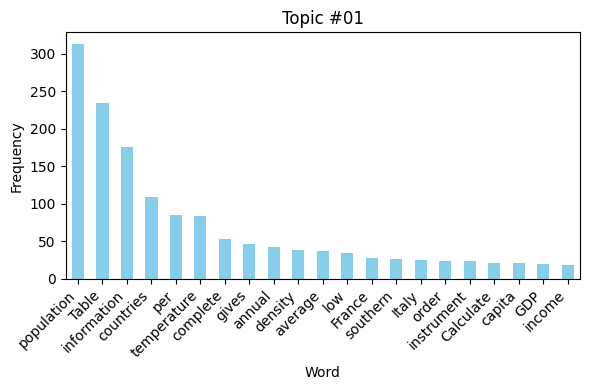

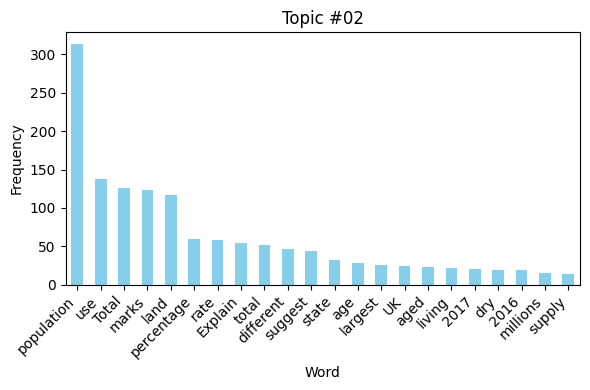

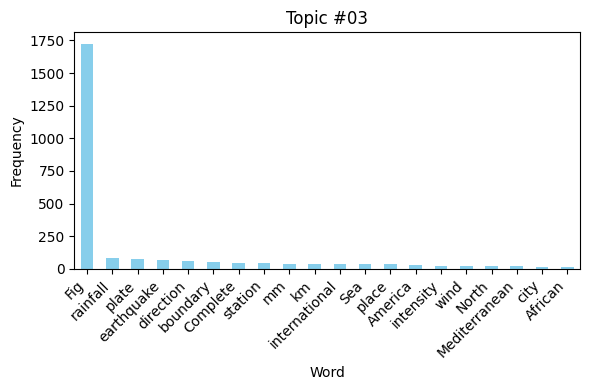

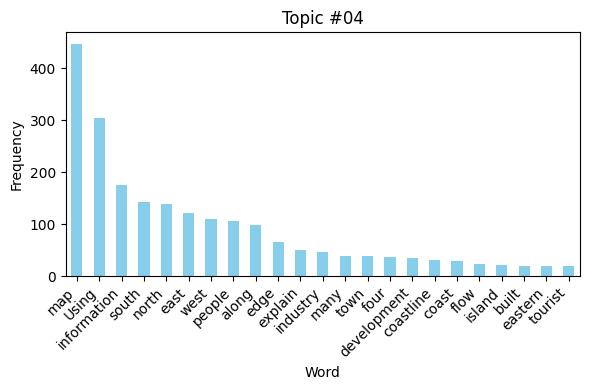

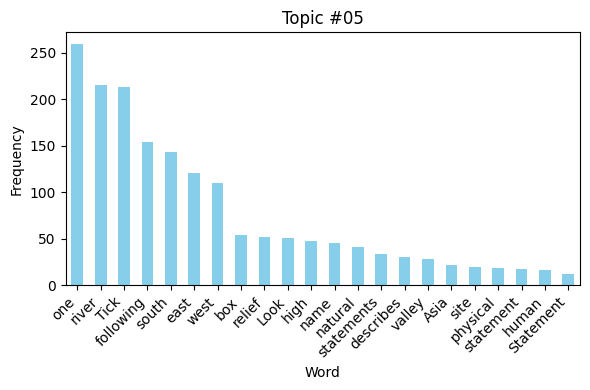

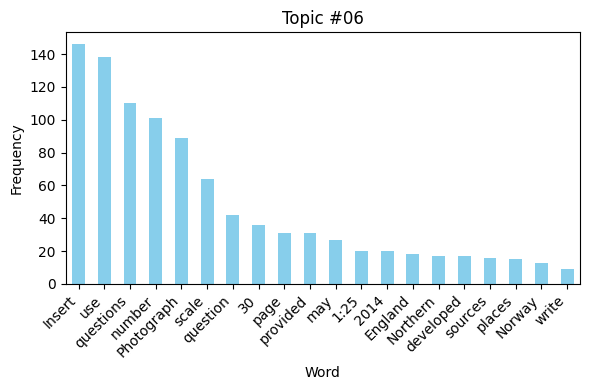

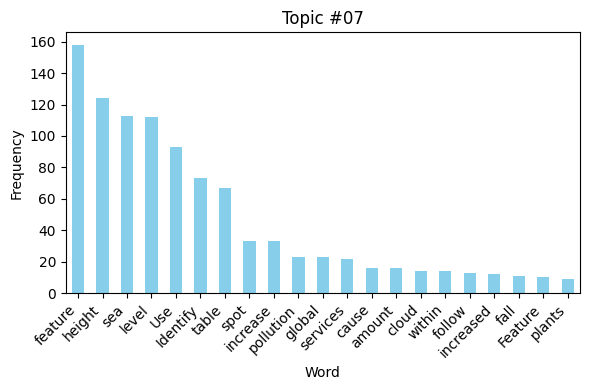

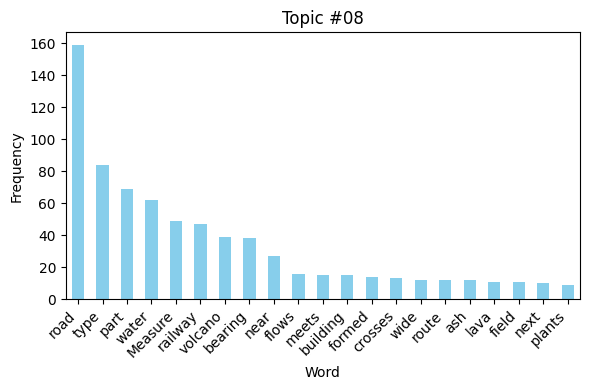

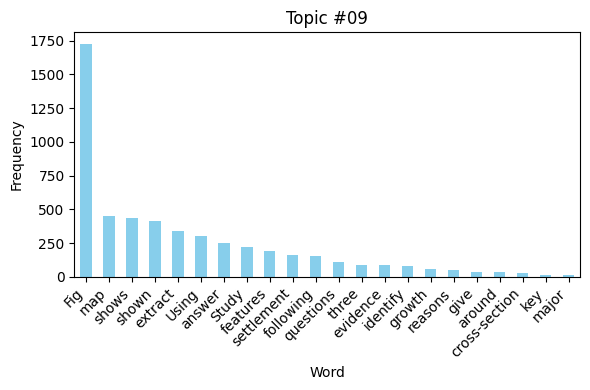

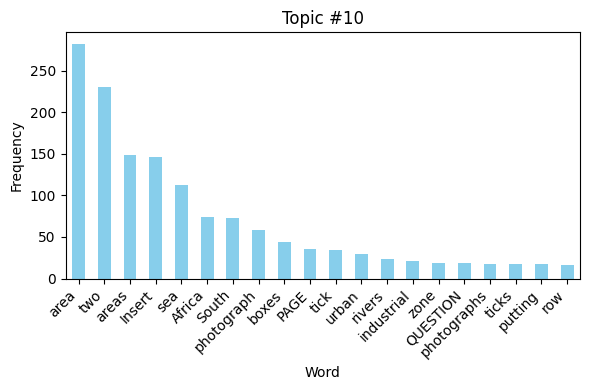

In [ ]:
def plot_bar_charts(model, num_topics):
    word_dict = {}
    for i in range(num_topics):
        words = model.show_topic(i, topn=20)
        word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]

    for topic, words in word_dict.items():
        plt.figure(figsize=(6, 4))
        ax = plt.subplot(111)
        split_words = []
        for word in words:
            if '_' in word:
                split_words.extend(word.split('_'))
            else:
                split_words.append(word)
        word_freq = df.Token_Text.str.split(expand=True).stack().value_counts()
        freqs = word_freq[word_freq.index.isin(split_words)]
        freqs.sort_values(ascending=False).plot(kind='bar', color='skyblue', ax=ax)
        plt.title(topic)
        plt.xlabel('Word')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
# plot_word_clouds(lda_model,10)

plot_bar_charts(lda_model,10)
